In [0]:
import numpy as np
import pandas as pd
import tensorflow as tf
np.random.seed(42)
tf.random.set_seed(42)

In [0]:
import os

In [0]:
path = '/content/drive/My Drive/IIITH/GCN_KEGG/GCN_patient_matrix'

In [0]:
labels = '/content/drive/My Drive/IIITH/GCN_KEGG/patient_labels.csv'
y = pd.read_csv(labels, header=None)

In [0]:
X = []

In [6]:
for patient in range(889):
  filename = str(patient) + '.csv'
  print(filename)
  df = pd.read_csv(os.path.join(path,str(filename)), header=None)
  X.append(df.to_numpy())

0.csv
1.csv
2.csv
3.csv
4.csv
5.csv
6.csv
7.csv
8.csv
9.csv
10.csv
11.csv
12.csv
13.csv
14.csv
15.csv
16.csv
17.csv
18.csv
19.csv
20.csv
21.csv
22.csv
23.csv
24.csv
25.csv
26.csv
27.csv
28.csv
29.csv
30.csv
31.csv
32.csv
33.csv
34.csv
35.csv
36.csv
37.csv
38.csv
39.csv
40.csv
41.csv
42.csv
43.csv
44.csv
45.csv
46.csv
47.csv
48.csv
49.csv
50.csv
51.csv
52.csv
53.csv
54.csv
55.csv
56.csv
57.csv
58.csv
59.csv
60.csv
61.csv
62.csv
63.csv
64.csv
65.csv
66.csv
67.csv
68.csv
69.csv
70.csv
71.csv
72.csv
73.csv
74.csv
75.csv
76.csv
77.csv
78.csv
79.csv
80.csv
81.csv
82.csv
83.csv
84.csv
85.csv
86.csv
87.csv
88.csv
89.csv
90.csv
91.csv
92.csv
93.csv
94.csv
95.csv
96.csv
97.csv
98.csv
99.csv
100.csv
101.csv
102.csv
103.csv
104.csv
105.csv
106.csv
107.csv
108.csv
109.csv
110.csv
111.csv
112.csv
113.csv
114.csv
115.csv
116.csv
117.csv
118.csv
119.csv
120.csv
121.csv
122.csv
123.csv
124.csv
125.csv
126.csv
127.csv
128.csv
129.csv
130.csv
131.csv
132.csv
133.csv
134.csv
135.csv
136.csv
137.csv
138.cs

In [0]:
X = np.asarray(X)

In [8]:
X.shape

(889, 111, 3)

In [0]:
y = y[1]

In [10]:
y.shape

(889,)

# Custom Attention Model

In [0]:
from tensorflow.keras import layers

In [0]:
# Defining pathway attention

class Pathway_Attention(layers.Layer):

  def __init__(self, a, d, p):
    super(Pathway_Attention, self).__init__()
    self.units = a
    self.input_dim = d
    self.alpha_dim = p

    self.w = self.add_weight(shape=(self.input_dim, self.units),
                             initializer='random_normal',
                             trainable=True)
    self.b = self.add_weight(shape=(self.units,),
                             initializer='zeros',
                             trainable=True)
    self.u = self.add_weight(shape=(self.units,),
                             initializer='random_normal',
                             trainable=True)
    self.alpha = self.add_weight(shape=(self.alpha_dim,),
                             initializer='zeros',
                             trainable=False)

  def call(self, inputs):
    y_att = tf.math.tanh(tf.matmul(inputs, self.w) + self.b)
    logits = tf.linalg.matvec(y_att, self.u)
    # print(logits.shape)
    self.alpha = tf.nn.softmax(logits)
    return tf.transpose(tf.linalg.matvec(tf.transpose(inputs), self.alpha))


In [0]:
class EnsembleBlock(layers.Layer):

  def __init__(self):
    super(EnsembleBlock, self).__init__()
    self.ensemble_1 = Pathway_Attention(a=4, d=3, p=111)
    self.ensemble_2 = Pathway_Attention(a=4, d=3, p=111)
    self.ensemble_3 = Pathway_Attention(a=4, d=3, p=111)
    self.ensemble_4 = Pathway_Attention(a=4, d=3, p=111)
    self.ensemble_5 = Pathway_Attention(a=4, d=3, p=111)
    self.ensemble_6 = Pathway_Attention(a=4, d=3, p=111)
    self.ensemble_7 = Pathway_Attention(a=4, d=3, p=111)
    self.ensemble_8 = Pathway_Attention(a=4, d=3, p=111)
    self.ensemble_9 = Pathway_Attention(a=4, d=3, p=111)
    self.ensemble_10 = Pathway_Attention(a=4, d=3, p=111)
    self.ensemble_11 = Pathway_Attention(a=4, d=3, p=111)
    self.final = Pathway_Attention(a=4, d=3, p=11)

  def call(self, inputs):
    h1 = self.ensemble_1(inputs)
    h2 = self.ensemble_2(inputs)
    h3 = self.ensemble_3(inputs)
    h4 = self.ensemble_4(inputs)
    h5 = self.ensemble_5(inputs)
    h6 = self.ensemble_6(inputs)
    h7 = self.ensemble_7(inputs)
    h8 = self.ensemble_8(inputs)
    h9 = self.ensemble_9(inputs)
    h10 = self.ensemble_10(inputs)
    h11 = self.ensemble_11(inputs)
    h_mgd = [h1, h2, h3, h4, h5, h6, h7, h8, h9, h10, h11]
    h_mgd = tf.convert_to_tensor(h_mgd, dtype=tf.float32)
    return self.final(h_mgd)


In [0]:
class MAE_Model(tf.keras.Model):

    def __init__(self):
        super(MAE_Model, self).__init__()
        self.h_fin = EnsembleBlock()
        self.ipt = tf.keras.layers.InputLayer(input_shape=(1,3), batch_size=None)
        self.fc_1 = tf.keras.layers.Dense(16, activation='relu')
        self.fc_2 = tf.keras.layers.Dense(8, activation='relu')
        self.classifier = tf.keras.layers.Dense(3, activation='softmax')

    def call(self, inputs):
        x = self.h_fin(inputs)
        x = tf.reshape(x, (1,3))
        # print(x)
        x = self.ipt(x)
        x = self.fc_1(x)
        x = self.fc_2(x)
        return self.classifier(x)


In [0]:
mae = MAE_Model()

In [0]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
ce_loss_fn = tf.keras.losses.CategoricalCrossentropy()

In [0]:
acc_metric = tf.keras.metrics.Accuracy()

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

In [19]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((666, 111, 3), (223, 111, 3), (666,), (223,))

In [0]:
dataset_train = tf.data.Dataset.from_tensor_slices((X_train, y_train))

In [21]:
epochs = 10

for epoch in range(epochs):
  print('Start of epoch %d' % (epoch,))

  # Iterate over the batches of the dataset.
  for train_x, train_y in dataset_train:
    with tf.GradientTape() as tape:
      preds = mae(train_x)
      # Compute reconstruction loss
      train_y = tf.one_hot(train_y, depth=3)
      # print(preds)
      train_y = tf.reshape(train_y, (1,3))
      # print(y_train)
      loss = ce_loss_fn(train_y, preds)
      # print(loss)

    grads = tape.gradient(loss, mae.trainable_weights)
    optimizer.apply_gradients(zip(grads, mae.trainable_weights))

    acc_metric.update_state(np.argmax(train_y), np.argmax(preds))

  print('epoch %s: train mean accc = %s' % (epoch, acc_metric.result()))

Start of epoch 0

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

epoch 0: train mean accc = tf.Tensor(0.8798799, shape=(), dtype=float32)
Start of epoch 1
epoch 1: train mean accc = tf.Tensor(0.9226727, shape=(), dtype=float32)
Start of epoch 2
epoch 2: train mean accc = tf.Tensor(0.9379379, shape=(), dtype=float32)
Start of epoch 3
epoch 3: train mean accc = tf.Tensor(0.9455706, shape=(), dtype=float32)
Start of epoch 4
epoch 4: train mean accc = tf.Tensor(0.95015013, shape=(), dtype=float32)
Start of epoch 5
epoch 5: train mean accc = tf.Tensor(0.9

In [0]:
dataset_test = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [0]:
y_test_preds = []
y_true = []

In [0]:
for test_x, test_y in dataset_test:
   p = mae(test_x)
   y_test_preds.append(tf.argmax(p, axis=-1))
   y_true.append(test_y)

In [25]:
from sklearn.metrics import classification_report
target_names = ['class 0', 'class 1', 'class 2']
print(classification_report(y_true, y_test_preds, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.97      0.95      0.96        73
     class 1       0.98      0.98      0.98       130
     class 2       0.91      1.00      0.95        20

    accuracy                           0.97       223
   macro avg       0.95      0.97      0.96       223
weighted avg       0.97      0.97      0.97       223



# Stratified K-fold

In [0]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)

In [27]:
for train_index, test_index in skf.split(X, y):
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]
  dataset_train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
  dataset_test = tf.data.Dataset.from_tensor_slices((X_test, y_test))
  print("------------FOLD---------------")
  mae = MAE_Model()
  acc_metric = tf.keras.metrics.Accuracy()
  optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
  ce_loss_fn = tf.keras.losses.CategoricalCrossentropy()

  for epoch in range(10):
    print('Start of epoch %d' % (epoch,))

    # Iterate over the batches of the dataset.
    for train_x, train_y in dataset_train:
      with tf.GradientTape() as tape:
        preds = mae(train_x)
        # Compute reconstruction loss
        train_y = tf.one_hot(train_y, depth=3)
        # print(preds)
        train_y = tf.reshape(train_y, (1,3))
        # print(y_train)
        loss = ce_loss_fn(train_y, preds)
        # print(loss)

      grads = tape.gradient(loss, mae.trainable_weights)
      optimizer.apply_gradients(zip(grads, mae.trainable_weights))

      acc_metric.update_state(np.argmax(train_y), np.argmax(preds))

    print('epoch %s: train mean accc = %s' % (epoch, acc_metric.result()))
  
  y_test_preds = []
  y_true = []
  for test_x, test_y in dataset_test:
    p = mae(test_x)
    y_test_preds.append(tf.argmax(p, axis=-1))
    y_true.append(test_y)
  target_names = ['class 0', 'class 1', 'class 2']
  print(classification_report(y_true, y_test_preds, target_names=target_names))

------------FOLD---------------
Start of epoch 0

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

epoch 0: train mean accc = tf.Tensor(0.8101266, shape=(), dtype=float32)
Start of epoch 1
epoch 1: train mean accc = tf.Tensor(0.87482417, shape=(), dtype=float32)
Start of epoch 2
epoch 2: train mean accc = tf.Tensor(0.90904826, shape=(), dtype=float32)
Start of epoch 3
epoch 3: train mean accc = tf.Tensor(0.9254571, shape=(), dtype=float32)
Start of epoch 4
epoch 4: train mean accc = tf.Tensor(0.9350211, shape=(), dtype=float32)
Start of epoch 5
epoch 5

<BarContainer object of 111 artists>

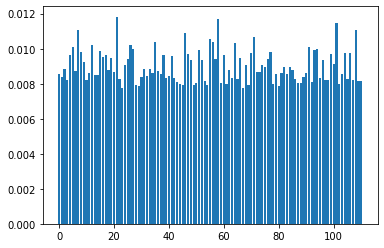

In [28]:
import matplotlib.pyplot as plt
x = [i for i in range(111)]
plt.bar(x, mae.h_fin.ensemble_1.alpha)

In [0]:
df = pd.DataFrame(mae.h_fin.ensemble_1.alpha.numpy())

In [0]:
pathway_file_map = {'hsa04064 .csv': 0, 'hsa01522 .csv': 1, 'hsa04066 .csv': 2, 'hsa03320 .csv': 3, 'hsa04068 .csv': 4, 'hsa04010 .csv': 5, 'hsa04071 .csv': 6, 'hsa04012 .csv': 7, 'hsa04072 .csv': 8, 'hsa04014 .csv': 9, 'hsa04110 .csv': 10, 'hsa04015 .csv': 11, 'hsa04115 .csv': 12, 'hsa04020 .csv': 13, 'hsa04137 .csv': 14, 'hsa04022 .csv': 15, 'hsa04140 .csv': 16, 'hsa04024 .csv': 17, 'hsa04144 .csv': 18, 'hsa04145 .csv': 19, 'hsa04062 .csv': 20, 'hsa04150 .csv': 21, 'hsa04151 .csv': 22, 'hsa04152 .csv': 23, 'hsa04210 .csv': 24, 'hsa04211 .csv': 25, 'hsa04216 .csv': 26, 'hsa04217 .csv': 27, 'hsa04218 .csv': 28, 'hsa04261 .csv': 29, 'hsa04270 .csv': 30, 'hsa04310 .csv': 31, 'hsa04340 .csv': 32, 'hsa04350 .csv': 33, 'hsa04360 .csv': 34, 'hsa04370 .csv': 35, 'hsa04371 .csv': 36, 'hsa04380 .csv': 37, 'hsa04390 .csv': 38, 'hsa04510 .csv': 39, 'hsa04520 .csv': 40, 'hsa04530 .csv': 41, 'hsa04550 .csv': 42, 'hsa04610 .csv': 43, 'hsa04611 .csv': 44, 'hsa04620 .csv': 45, 'hsa04621 .csv': 46, 'hsa04622 .csv': 47, 'hsa04623 .csv': 48, 'hsa04625 .csv': 49, 'hsa04630 .csv': 50, 'hsa04650 .csv': 51, 'hsa04657 .csv': 52, 'hsa04658 .csv': 53, 'hsa04659 .csv': 54, 'hsa04660 .csv': 55, 'hsa04662 .csv': 56, 'hsa04664 .csv': 57, 'hsa04666 .csv': 58, 'hsa04668 .csv': 59, 'hsa04670 .csv': 60, 'hsa04713 .csv': 61, 'hsa04714 .csv': 62, 'hsa04720 .csv': 63, 'hsa04722 .csv': 64, 'hsa04723 .csv': 65, 'hsa04724 .csv': 66, 'hsa04725 .csv': 67, 'hsa04726 .csv': 68, 'hsa04728 .csv': 69, 'hsa04730 .csv': 70, 'hsa04750 .csv': 71, 'hsa04810 .csv': 72, 'hsa04910 .csv': 73, 'hsa04911 .csv': 74, 'hsa04912 .csv': 75, 'hsa04913 .csv': 76, 'hsa04915 .csv': 77, 'hsa04916 .csv': 78, 'hsa04917 .csv': 79, 'hsa04918 .csv': 80, 'hsa04919 .csv': 81, 'hsa04920 .csv': 82, 'hsa04921 .csv': 83, 'hsa04922 .csv': 84, 'hsa04923 .csv': 85, 'hsa04924 .csv': 86, 'hsa04925 .csv': 87, 'hsa04926 .csv': 88, 'hsa04927 .csv': 89, 'hsa04928 .csv': 90, 'hsa04929 .csv': 91, 'hsa04935 .csv': 92, 'hsa04960 .csv': 93, 'hsa04961 .csv': 94, 'hsa04962 .csv': 95, 'hsa04970 .csv': 96, 'hsa04971 .csv': 97, 'hsa04972 .csv': 98, 'hsa04973 .csv': 99, 'hsa04976 .csv': 100, 'hsa04978 .csv': 101, 'hsa04979 .csv': 102, 'hsa05200 .csv': 103, 'hsa05202 .csv': 104, 'hsa05204 .csv': 105, 'hsa05205 .csv': 106, 'hsa05211 .csv': 107, 'hsa05230 .csv': 108, 'hsa05231 .csv': 109, 'hsa05235 .csv': 110}

In [0]:
# list out keys and values separately 
key_list = list(pathway_file_map.keys()) 
val_list = list(pathway_file_map.values()) 

In [0]:
df['pathway'] = key_list

In [33]:
df

,0,pathway
0,0.008568,hsa04064 .csv
1,0.008363,hsa01522 .csv
2,0.008816,hsa04066 .csv
3,0.008191,hsa03320 .csv
4,0.009655,hsa04068 .csv
...,...,...
106,0.009747,hsa05205 .csv
107,0.008217,hsa05211 .csv
108,0.011075,hsa05230 .csv
109,0.008168,hsa05231 .csv


In [0]:
full_dataset = tf.data.Dataset.from_tensor_slices((X, y))

In [0]:
pathway_scores = []

In [0]:
for patient, label in full_dataset:
  _ = mae(patient)
  scores = mae.h_fin.ensemble_1.alpha.numpy()
  scores_norm = scores/np.linalg.norm(scores)
  pathway_scores.append(scores_norm)

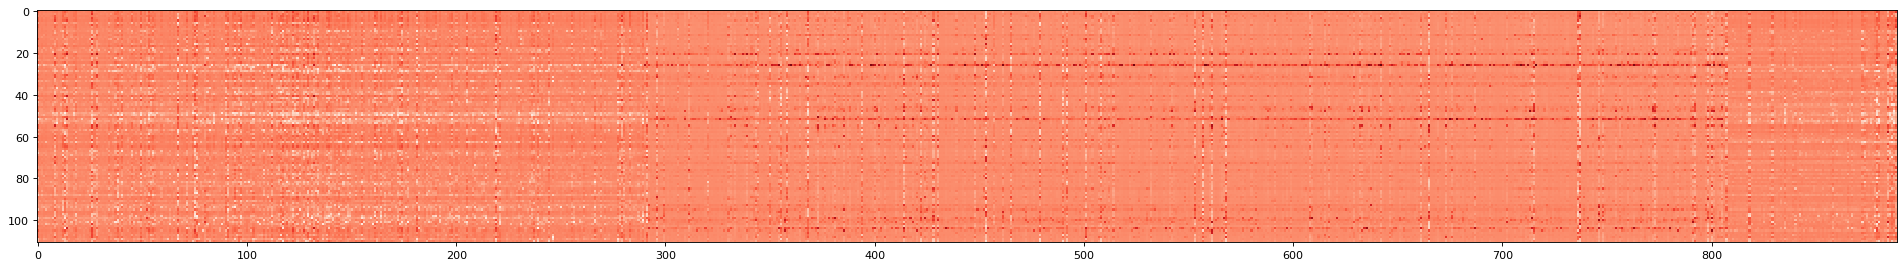

In [57]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(30, 60), dpi=80, facecolor='w', edgecolor='k')
plt.imshow(np.asarray(pathway_scores).T, cmap='Reds', interpolation='nearest')
plt.show()

In [70]:
pathway_scores[410][26]

0.10363153

In [69]:
pathway_scores[101][26]

0.08920975

In [71]:
pathway_scores[830][26]

0.08869825

In [73]:
key_list[26] #Ferroptosis

'hsa04216 .csv'

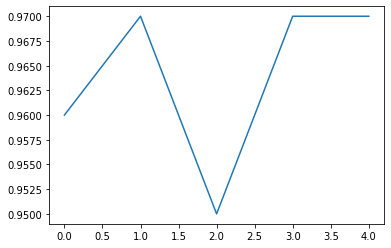

In [2]:
import matplotlib.pyplot as plt
plt.plot([0.96, 0.97, 0.95, 0.97, 0.97])